# Unsupervised Machine Learning - Visualising High-Dimensional Data and Discovering Patterns

Dr Jack Yang 

jianliang.yang1@unsw.edu.au

*School of Material Science and Engineering, UNSW*

*Advanced Materials and Manufacturing Futures Institute, UNSW*

August 2020

## Aims

In the previous workshop ([Machine Learning 101 with Python](https://colab.research.google.com/drive/1Ha_yWX3uguN64yBBDYs_GO5rnzItAmO4)), we introduced and demonstrated the concept of **supervised learning** (or regressions) in the field of machine learning (ML). As we discussed, the idea of using supervised learning is to establish an unknown, often high-dimensional, relationship between the target properties $\mathbf{Y}$ and observables $\mathbf{X}$, $\mathbf{Y}=f^{ML}(\mathbf{X})$. It is called supervised learning because we can directly assess the equality of the learned relationship based on the error between the true and ML-predicted values $|\mathbf{Y}^{true}-\mathbf{Y}^{ML}|$.

In this lecture, we will be looking at another important category of ML, the **unsupervised learning**. Here, we are ususally only given with a series of (high-dimensional) features $\mathbf{X}$, and aim to rely on the ML method to help us *discovering intriguing or hidden features* among this set of data. Hence, in general, there is *generally* no targeted metric to help us assess the quality of the learning outcome.

The most typical use case of unsupervised learning is to perform so-called ***dimensionality reduction***, that is to project data in a high--dimensioal space to the 2 (or 3) dimensional space that we can easily visualise. As such, this is an important category of tools for ***data visualisations***. On top of that, we can apply what normally referred to as ***clustering analysis*** to discover data points that can be clustered together, meaning that data that have close relationship with each others.

Nevertheless, it is still very common that our data $\mathbf{X}$ still comes together with some properties $\mathbf{Y}$, which we can use them to *decorate* the low-dimensional projections to help us discover which subsect of features $\{\mathbf{x}|\mathbf{x}\in\mathbf{X}\}$ play significant roles in determining $\mathbf{Y}$. This can help us to qualitatively assess whether the outcomes of unsupervised learning are sensible.

## Setting the Stage - Just a Bit of Physics

![alt text](https://drive.google.com/uc?id=1rwahMdn_hnoWXpBlJximgadz5ze63fYJ)

The task that we will be working on this time requires a bit of physics. Don't worry, just a bit. Let's walk through it.

We all know materials can be classified into two (or three) categories:
* **Metals** - the things that conduct electricities, and
* **Semiconductors and/or Insulators** - things that conduct electricities poorly or not at all.

Common knowledge tells us that copper is metal and silicon is semiconductor. But there are literally millions of different materials exist or can probabaly be made in this world. How can we go about distinguishing these materials, and find out which sets of them might behave similarly in terms of their electrical behaviours?

Well, fundamentally, this is determined by what we called **electronic density-of-states**. As shown above, if you have never heard about it, what this is, is basically **a mathematical function $f(E)$ with respect to energy $E$**, that tells us **how much electrons of energy $E$ can a material hold**. 

For semiconductors/insulators, there exists a ***GAP*** within a particular range of energies, meaning the function has a zero value. Whereas for metals, there is no such thing!

So the question basically becomes the following:

**If we are given 1000 unknown materials, each with a density-of-states function, how can we use unsupervised learnings to discover common features in these 1000 materials?**

Or if you prefer:

**How to compare 1000 one-dimensional mathematical functions?**

If this still doesnt ring a bell to you, well, depends on your background, it could mean:

* [Molecular biologists] - How to algorithmically compare a bunch of electrophoresis pattern?
* [Material Scientists] - How to algorithmically compare the X-ray diffraction pattern for different materials?
* [Chemists] - How to algorithmically compare infrared, UV or mass spectra for different molecules?
* [Electrical Engineerings] - Is there a pattern in the elctrical signals measured across a series of experiments?

## The Data

The [Materials Project](https://materialsproject.org/) host about **60,000** calculated electronic structure informations for inorganic materials, that are either known to exist or predicted to be stable.

From here, I extracted **1,348** pieces of data for compounds that are made of only two different elements,  where one of the consituent elements being either oxygen or nitrogen. While it is possible to use Python to download the data straight away from the Materials Project website, the process is quite slow, so I have pre-stored them in a JSON file, which we can quickly load it up. 

In [1]:
import json
with open('./DOS_data.json') as f:
    data = json.load(f)

Here, the data is stored as a Python *dictionary* object. The key is a unique ID provided by the *Materials Project Database*. The value for each item is another dictionary which contains following attributes:
* formula - The chemical formula for the compound
* band_gap - The value of electronic band gap for this material. (Note that, if you are a physicist, the band gap value from the materials project are not very accurate, but for this demo, it is not a big issue.)
* dos - The density-of-states data, which is stored as a dictionary of x (energy) with its corresponding y (density-of-states)

So, let's first inspect some data to appreciate how the electronic density-of-states looks like between different pairs of materials.

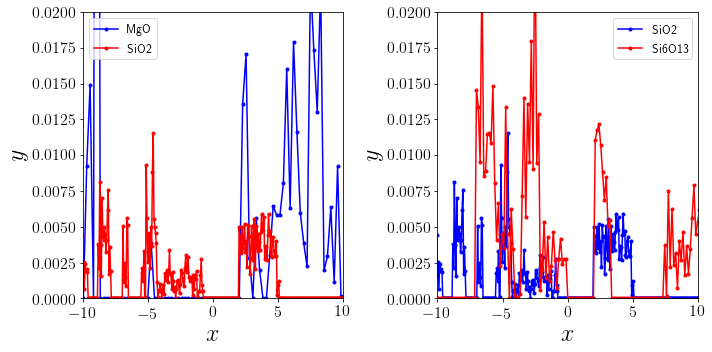

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (15, 5),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
pylab.rcParams.update(params)
from matplotlib import rc
rc('text', usetex=True)
from scipy.interpolate import interp1d
import numpy as np 

def get_DOS_for_materials(data,m):
    for k in data.keys():
        if m in data[k]['formula']:
            x = list(sorted(data[k]['dos'].keys()))
            y = [data[k]['dos'][_x] for _x in x]
            y = [_y/sum(y) for _y in y]
            x = list(sorted([float(_x) for _x in x]))
            return x,y

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x,y=get_DOS_for_materials(data,'MgO')
plt.plot(x,y,'b.-',label='MgO')

x,y=get_DOS_for_materials(data,'SiO2')
plt.plot(x,y,'r.-',label='SiO2')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.xlim([-10,10])
plt.ylim([0,0.02])

plt.subplot(1,2,2)
x,y=get_DOS_for_materials(data,'SiO2')
plt.plot(x,y,'b.-',label='SiO2')

x,y=get_DOS_for_materials(data,'Si6O13')
plt.plot(x,y,'r.-',label='Si6O13')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.xlim([-10,10])
plt.ylim([0,0.02])
plt.tight_layout()
plt.show()

## Data Representation (Featurisation)
One of the most important pre-requisits for ML is to **mathematically represent the data** such that it can be learned by the algorithm and reveal interesting patterns in the data.  After all, ML contains a great deal of maths, many of them have actually been devised for a long time, all the way back to mathematicians such as Gauss and Lapalace!

This is often the most challenging, yet most interesting part of ML, which has been heavily researched upon. However, we are not able to go too deep into this topic here. We will just demonstrate some of the concepts here.

**Firstly**, the process of featurisation is to convert the input that we want to compare, in this case, density-of-states for a materials at different energies, into a (high-dimensional vector). Basically this means that we can simply collate all $y$ values according to the ascending order of $x$ into a high-dimensional vector and use it as the representation of our data.

This is illustrated as following:

![alt text](https://drive.google.com/uc?id=1mkfBMYRpOPJI_sCqrcQe5LbTPnOQLY9v)

**Secondly**, we need to make sure all representations are **standardised**. This means that, if we use a 100-dimensional vector $\mathbf{Y}$ as our data deature for each material, then every single element $y_{i}\in\mathbf{Y}$ must correspond to the functional value at  exactly the same $x_i$ for all the materials we want to compare.

So, in the following process of building the **feature vector** for all 1,348 pieces of data, we need to achieve this via two operations:
* Based on the raw data, we *interpolate* the DOS values on a fixed set of $x$, and
* *Zero padding*, meaning if the raw data misses some $y_i$ values at some $x_i$, we will fill it with zero. 
This is illustrated as following:

(30,) (30,)


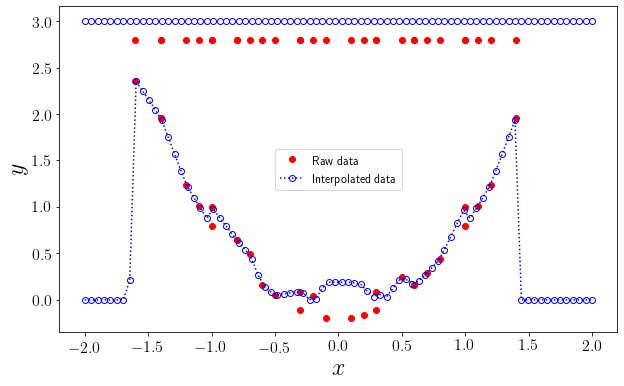

In [3]:
import random

#Prepare some Raw data
raw_x=[x+random.randrange(-1,1)*0.1 for x in np.arange(-1.5,1.5,0.1)]
raw_y=[(_x)**2+random.randrange(-1,1)*0.2 for _x in raw_x]
print(np.shape(raw_x),np.shape(raw_y))

plt.figure(figsize=(10,6))
plt.plot(raw_x,raw_y,'or',label='Raw data')
plt.plot(raw_x,[2.8 for _ in raw_x],'or') #this plots the distribution of x in the raw data

#The process of zero padding the data
raw_x_min = min(raw_x)
raw_x_max = max(raw_x)
interp_x_min = -2.1
interp_x_max = 2.1

if raw_x_min>interp_x_min:
    raw_x = np.concatenate((np.arange(interp_x_min,raw_x_min-0.0025,0.05), raw_x))
    raw_y = np.concatenate(([0 for _ in np.arange(interp_x_min,raw_x_min-0.0025,0.05)], raw_y))
if raw_x_max<interp_x_max:
    raw_x = np.concatenate((raw_x, np.arange(raw_x_max+0.0025,interp_x_max,0.05)))
    raw_y = np.concatenate((raw_y, [0 for _ in np.arange(raw_x_max+0.0025,interp_x_max,0.05)]))

#Interpolating the data and plot the interploated ones
interpolated = interp1d(raw_x, raw_y, kind='linear')
            
new_x = np.linspace(interp_x_min+0.1, interp_x_max-0.1, num=80, endpoint=True)
new_y = abs(interpolated(new_x))

plt.plot(new_x,new_y,'o:b',label='Interpolated data',markerfacecolor='None')
plt.plot(new_x,[3 for _ in new_x],'ob',markerfacecolor='None') #show that in the interpolated data, x are evenly spreaded

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

Now let's prepare all our raw data into the feature vectors. 

Note, this bit of code takes some time to run.

In [18]:
from tqdm.notebook import tnrange

names=[]
gaps=[]
feature_matrix=[]

for k in tnrange(len(data.keys())):
    k=list(data.keys())[k]
    name=data[k]['formula']
    x = list(sorted(data[k]['dos'].keys()))
    raw_y = [data[k]['dos'][_x] for _x in x]
    raw_x = [float(_x) for _x in x]
    
    gaps.append(data[k]['band_gap'])
    
    raw_x_min = min(raw_x)
    raw_x_max = max(raw_x)
    interp_x_min = -3.1
    interp_x_max = 3.1

    if raw_x_min>interp_x_min:
        raw_x = np.concatenate((np.arange(interp_x_min,raw_x_min-0.0025,0.05), raw_x))
        raw_y = np.concatenate(([0 for _ in np.arange(interp_x_min,raw_x_min-0.0025,0.05)], raw_y))
    if raw_x_max<interp_x_max:
        raw_x = np.concatenate((raw_x, np.arange(raw_x_max+0.0025,interp_x_max,0.05)))
        raw_y = np.concatenate((raw_y, [0 for _ in np.arange(raw_x_max+0.0025,interp_x_max,0.05)]))
    
    dos_total = interp1d(raw_x, raw_y, kind='linear')
    new_x = np.linspace(interp_x_min+0.1, interp_x_max-0.1, num=500, endpoint=True)
    
    #note that here we also do a bit of normalization of the data, so the sum of all y goes to one
    #this is also very typical in the process of featurisation!
    new_y = abs(dos_total(new_x))
    new_y = np.array([_y/sum(new_y) for _y in new_y])
    
    names.append(name)
    
    #We collect all the feature vectors into a matrix, which is typically called the feature matrix in ML!
    feature_matrix.append(new_y)

Before we move on, let's just plot the feature matrix to see how all these features are like across the entire dataset. 

Text(0, 0.5, 'Dimension')

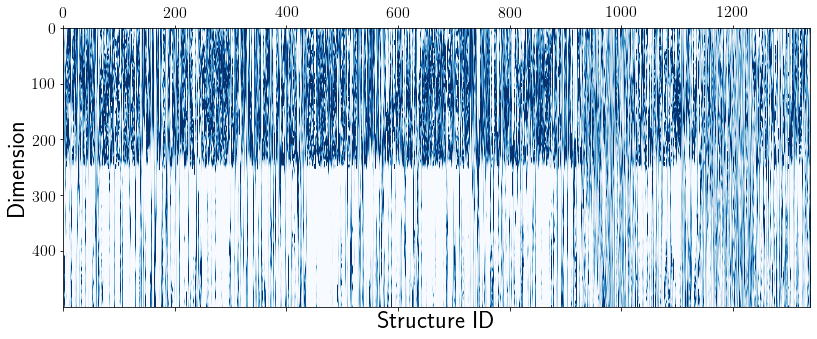

In [19]:
plt.matshow(np.transpose(feature_matrix),cmap=plt.cm.Blues)
plt.clim(0,0.005)
plt.xlabel("Structure ID")
plt.ylabel("Dimension")

## The similarity Kernel/Distance Matrix

As you can already see here, there are a lot of cases that show up with highly similar pattern. What we will do now is to quantify these similarities, which can be subsequently analysed using unsupervised ML.

**Similarity** is a very important concept in ML. In the context of unsupervised ML, recurrent patterns appears among the data, because there exists subsets of data that are highly similar to each other. There are many ways to quantify the similarity between two feature vectors in high dimensional space, each one has its own pros and cons. There are also specicialised similarity metrics that aims to highlight different features in the data, and, not surprised, the mathematics also becomes complicated.

Here, we will just use the simplest similarity metric, the ***cosine similarity***. If you remember your first year linear algebra, the cosine similarity simply is a measure of the angle formed between two vectors, and two vectors are identical to each other if they are parallel in the ***hyperspace***, or simply with a cosine similarity of ONE. Mathematically

$$\mbox{Sim}(\mathbf{v_{1}},\mathbf{v_{2}})=\frac{\mathbf{v_{1}}\cdot\mathbf{v_{2}}}{||\mathbf{v_{1}}||\cdot||\mathbf{v_{2}}||}$$

If we compare all the ***Pair-Wise*** similarities between all pairs of samples in the dataset, we can store all these single valued similarity into a matrix, which is commonly referred to as the ***Similarity Kernel*** ($\mathbf{K}$).

On the other hand, if you think about the feature vector represents ***a point in the hyperspace***, what we can measure equivalently will be the distance $R$ between these two points in the high-dimensional space. In fact, the ***distance matrix*** ($\mathbf{D}$) is what normally needed in unsupervised ML for the purpose of dimensionality reduction. Generally, distance matrix and similarity matrix are inter-convertable. In our case,

$$\mathbf{D}=\mathbf{1}-\mathbf{K}$$

In [20]:
from scipy.spatial.distance import cosine
distance_matrix=np.zeros([np.shape(feature_matrix)[0],np.shape(feature_matrix)[0]])
for i in tnrange(np.shape(feature_matrix)[0]):
    for j in range(i,np.shape(feature_matrix)[0]):
        distance_matrix[i][j]=cosine(feature_matrix[i],feature_matrix[j])
        distance_matrix[j][i]=distance_matrix[i][j]

And we can inspect what this ***distance matrix*** looks like. Mathematically, the kernel matrix is always a positively defined diagonal matrix.

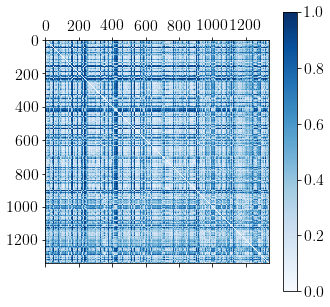

In [21]:
plt.matshow(distance_matrix,cmap=plt.cm.Blues)
plt.colorbar()

## Dimensionality Reduction - Produce a Two-Dimensional Electronic Structure Map with Unsupervised ML

![alt text](https://drive.google.com/uc?id=11zoY0IATCFAs2Wii_bA978aUgBX193ij)

The method that we will be using here is called **ISOMAP**, which belongs to a category of ML algorithm called [manifold learning](https://scikit-learn.org/stable/modules/manifold.html#manifold). In a very hand-wavy argument, what we are trying to achieve is to reonstruct a two-dimensional projection of the high-dimensional data, in which the distance between any two points in the low-dimensional projection $d$ should match those in the high-dimensional space $D$ as much as possible.

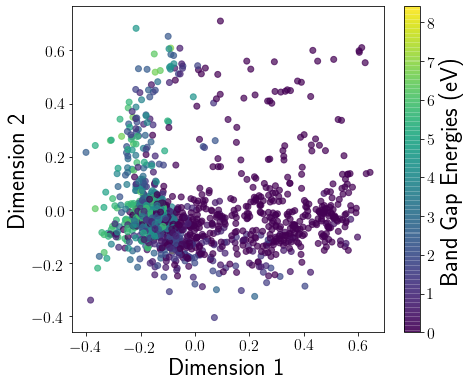

In [29]:
from sklearn.manifold import Isomap
plt.figure(figsize=(7,6))
embedding = Isomap(n_components=2,metric='precomputed',n_neighbors=5)
X_transformed = embedding.fit_transform(distance_matrix)
plt.scatter(X_transformed[:,0],X_transformed[:,1],marker='o',c=gaps,alpha=0.7)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Band Gap Energies (eV)')

As you can see some separations between points with small band gap from those with larger band gap. Of course, this division is not exactly a binary one. One reason is because we are comparing the entire feature of the DOS curve, not only just the 'gap region', so the similarity measures could have taken up extra features that could provide more information than simply just the band gaps.

## Cluster detection

The other reason why the two-dimensional projection does not lead to a clear distinguishment of points is because, during the dimensionality reduction process, some of the spatial relationships between points in the high-dimensional spaces could be distorted, even though we are trying to preserve the correspondence between low and high dimensional space as much as possible. In another word, points that appear closer together in the projection may not always reflect the truth in the high--dimensional space. 

The simplest arugment is to inspect two person standing in a line. If you look directly along the line joining the two persons, they condensed into one point, appearing to be not separated, only when you look from the side, you can get a better appreciation on how far they are separated. So an analogy of dimensionality reduction is to find a view point where we can best comprehend the distance relationships among $n$ points, but some distortions are nevertheless, unavoidable. 

As a sanity check, one thing we can do is to use the **distance matrix** directly and apply another unsupervised ML technique, called [clustering](https://scikit-learn.org/stable/modules/clustering.html) to find points that are closer together in the high-dimensional space. We can then annotate the low-dimensional projection to see how good it reveals the distance relationship in high dimensional space.

Here, we will use one type of clustering algorithms called **KMeans** to detect the number of clusters in the data. The algorithm works relatively simple. You specify the number of clusters (K) that you would like to find amongst your data, then the algorithms select K points in the space as the ***centroids of the clusters***. The alogrithm then tries to decide which centroid is a given point close to and assign the point to that centroid. The algorithm iterates by ***maximising the pairwise distances between centroids*** while updating ***points that belong to a specific centroid/cluster***.

Number of clusters detected: 3
Number of noise detected: 0


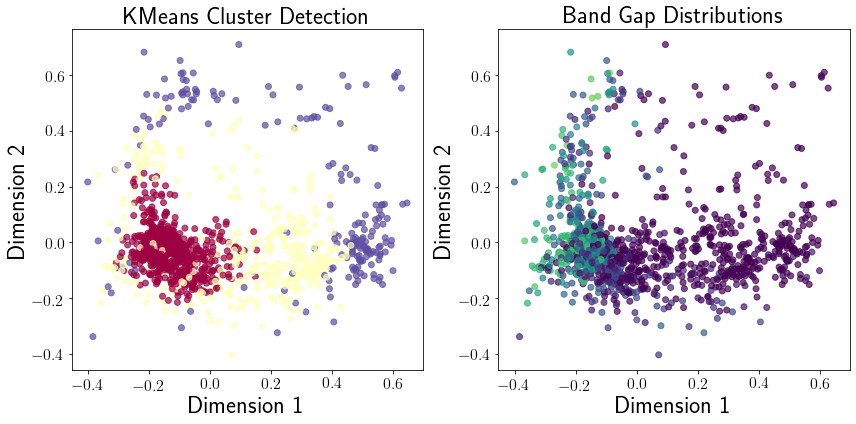

In [51]:
from sklearn.cluster import KMeans
db = KMeans(n_clusters=3,precompute_distances=True).fit(distance_matrix)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Number of clusters detected: "+str(n_clusters_))
print("Number of noise detected: "+str(n_noise_))

plt.figure(figsize=(12,6))
unique_labels = set(labels)
_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
colors = [_colors[i] for i in labels ]
plt.subplot(1,2,1)
plt.scatter(X_transformed[:,0],X_transformed[:,1],marker='o',c=colors,alpha=0.7)
plt.title("KMeans Cluster Detection")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.subplot(1,2,2)
plt.scatter(X_transformed[:,0],X_transformed[:,1],marker='o',c=gaps,alpha=0.7)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title("Band Gap Distributions")
plt.tight_layout()

As you can see here, there are some correspondence between the red and yellow clusters that can be roughly correlated with materials of large/small band gaps. This shows that our analysis is somehow on the right track, and it provides us a good visual understanding on the dataset. 

Till this point, we have gone through quite a few concepts in ML in a fast pace:
* The idea of data featurisation
* The similarity kernel and distance matrix
* The basic principle of dimensionality reduction/manifold learning, and
* The detection of clusters in the data

However, as you can see, one big problem for unsupervised ML is that, there is generally ***no concrete criteria for determining the quality of the projection***. It really relies on the person who is using the algorithm to have a good understanding on the data and decide whether the learning approach has lead to something sensible. 

In a proper research setting, the first thing you may further optimise the data featurisation step to see if it is the best way to represent your data, so you get out the information you want. If you data sets do come with some associated properties, one good approach to test if the featurisation is good will be first to do a ***supervised learning*** to predict the properties and use the prediction error to optimise the feature vectors/simiarity kernel. With the optimised kernel, one can then perform an ***unsupervised learning*** to plot the data.

For those who are math-savy, you might also want to check out the following article, where you can combine the error functions in supervised and unsupervised ML to achieve the best outcomes from both world:

https://arxiv.org/abs/2002.05076